Ước lượng Lipschitz theo y: 1
Ước lượng Lipschitz theo y_delay: 1
Độ biến thiên (gradient) delay: 0
(Nếu các giá trị này quá lớn, có thể báo hiệu vi phạm giả định Lipschitz.)

  [Giảm bước] t=-1.00000, h=1.265e-02, err=2.565e-03
  [Giảm bước] t=-1.00000, h=4.523e-03, err=4.011e-05
  [Giảm bước] t=-1.00000, h=2.706e-03, err=5.119e-06
  [Giảm bước] t=-1.00000, h=2.093e-03, err=1.832e-06
  [Giảm bước] t=-1.00000, h=1.841e-03, err=1.096e-06

--- KẾT QUẢ TÍNH ---
t = -1.00000, y = 1.00000000
t = -0.99816, y = 0.99632079
t = -0.99643, y = 0.99287631
t = -0.99476, y = 0.98954620
t = -0.99311, y = 0.98627450
t = -0.99148, y = 0.98303426
t = -0.98985, y = 0.97981227
t = -0.98823, y = 0.97660200
t = -0.98661, y = 0.97340020
t = -0.98499, y = 0.97020526
t = -0.98337, y = 0.96701637
t = -0.98175, y = 0.96383312
t = -0.98013, y = 0.96065532
t = -0.97851, y = 0.95748286
t = -0.97689, y = 0.95431571
t = -0.97527, y = 0.95115382
t = -0.97365, y = 0.94799719
t = -0.97203, y = 0.94484582
t = -0.97041, y

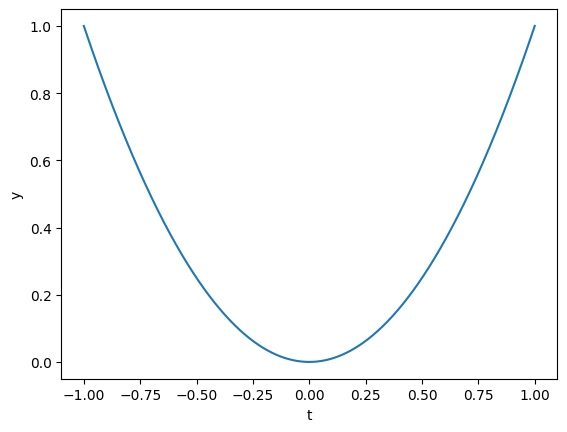

1236


In [5]:
import numpy as np

# 1) Hàm kiểm tra gần đúng tính Lipschitz và liên tục của tau
def check_conditions(f, tau, phi, t0, delta=1e-6):
    """
    Kiểm tra gần đúng các điều kiện Lipschitz của f theo y và y_delay,
    và tính liên tục của hàm delay tau.
    Chỉ dùng để cảnh báo sơ bộ.
    """
    y0 = phi(t0)  # Giá trị nghiệm tại t0
    tau0 = tau(t0, y0)
    y_delay0 = phi(t0 - tau0)
    
    f0 = f(t0, y0, y_delay0)
    
    # Sai phân hữu hạn theo y
    f_y = (f(t0, y0 + delta, y_delay0) - f0) / delta
    # Sai phân hữu hạn theo y_delay
    f_yd = (f(t0, y0, y_delay0 + delta) - f0) / delta
    
    L_y = abs(f_y)
    L_yd = abs(f_yd)
    
    # Độ liên tục của tau
    tau_cont = abs(tau(t0 + delta, y0) - tau0) / delta
    
    print("Ước lượng Lipschitz theo y: {:.4g}".format(L_y))
    print("Ước lượng Lipschitz theo y_delay: {:.4g}".format(L_yd))
    print("Độ biến thiên (gradient) delay: {:.4g}".format(tau_cont))
    print("(Nếu các giá trị này quá lớn, có thể báo hiệu vi phạm giả định Lipschitz.)\n")
    
    return L_y, L_yd, tau_cont

# 2) Nội suy Hermite bậc 3 để có nghiệm liên tục
def cubic_hermite(t, t0, t1, y0, y1, f0, f1):
    """
    Nội suy giá trị tại t ∈ [t0, t1] dùng Hermite bậc 3
    (dựa vào giá trị và đạo hàm tại 2 đầu).
    """
    s = (t - t0) / (t1 - t0)
    H00 = 2*s**3 - 3*s**2 + 1
    H10 = -2*s**3 + 3*s**2
    H01 = s**3 - 2*s**2 + s
    H11 = s**3 - s**2
    return (y0 * H00 
            + y1 * H10 
            + (t1 - t0) * (f0 * H01 + f1 * H11))

# 3) Lấy giá trị y(t_eval) bằng lịch sử + nội suy trên các nút đã tính
def get_y_at(t_eval, sol, phi, t0):
    # Nếu t_eval <= t0, dùng hàm lịch sử
    if t_eval <= t0:
        return phi(t_eval)
    # Nếu vượt ngoài phạm vi đã tính, trả về giá trị nút cuối
    if t_eval >= sol[-1]['t']:
        return sol[-1]['y']
    # Tìm đoạn [t_i, t_{i+1}] chứa t_eval
    for i in range(len(sol)-1):
        t_i = sol[i]['t']
        t_ip1 = sol[i+1]['t']
        if t_i <= t_eval <= t_ip1:
            y_i = sol[i]['y']
            y_ip1 = sol[i+1]['y']
            f_i = sol[i]['f']
            f_ip1 = sol[i+1]['f']
            return cubic_hermite(t_eval, t_i, t_ip1, y_i, y_ip1, f_i, f_ip1)
    return None

# 4) Thực hiện một bước RK4/RK3 để ước lượng sai số
def rk_step(t, y, h, sol, f, tau, phi, t0):
    # Tính y_delay cho stage 1
    y_delay = get_y_at(t - tau(t, y), sol, phi, t0)
    k1 = f(t, y, y_delay)
    
    # Stage 2
    t2 = t + h/2
    y2 = y + (h/2)*k1
    y_delay = get_y_at(t2 - tau(t2, y2), sol, phi, t0)
    k2 = f(t2, y2, y_delay)
    
    # Stage 3
    t3 = t + h/2
    y3 = y + (h/2)*k2
    y_delay = get_y_at(t3 - tau(t3, y3), sol, phi, t0)
    k3 = f(t3, y3, y_delay)
    
    # Stage 4
    t4 = t + h
    y4 = y + h*k3
    y_delay = get_y_at(t4 - tau(t4, y4), sol, phi, t0)
    k4 = f(t4, y4, y_delay)
    
    # Nghiệm bậc 4 (RK4)
    y_high = y + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    
    # Nghiệm bậc 3 (embedded)
    # (có nhiều cách xây dựng embedded RK3, ví dụ dùng Heun / classic, minh họa một biến thể đơn giản)
    y_rk3 = y + (h/4)*(k1 + 2*k2 + k3)  # hoặc 1 cách cổ điển
    # Tính sai số
    err = abs(y_high - y_rk3)
    
    return y_high, err, (k1, k2, k3, k4)

# 5) Thuật toán giải DDE bằng CRK (RK4 + Hermite) với bước tự điều chỉnh
def solve_dde_adaptive(f, tau, phi, t0, t_final, 
                       tol=1e-5, h_init=0.1, h_min=1e-8, h_max=0.5):
    """
    f, tau, phi như mô tả:
       - f(t, y, y_delay)
       - tau(t, y)
       - phi(t): lịch sử
    t0: thời điểm bắt đầu (ở đây t0=1)
    t_final: thời điểm kết thúc
    tol: ngưỡng sai số
    h_init, h_min, h_max: bước khởi tạo, nhỏ nhất, lớn nhất.
    Trả về: sol (list các dict {'t':, 'y':, 'f':})
    """
    sol = []
    # Giá trị ban đầu
    y0 = phi(t0)
    y_delay0 = phi(t0 - tau(t0, y0))  # vì t0=1 => t0 - tau(1,y0) = 1 - (log(1)+1)=0 => phi(0)=1
    f0 = f(t0, y0, y_delay0)
    sol.append({'t': t0, 'y': y0, 'f': f0})
    
    t = t0
    y = y0
    h = h_init
    
    while t < t_final:
        # Điều chỉnh để không vượt quá t_final
        if t + h > t_final:
            h = t_final - t
        
        # Tính một bước
        y_high, err, k_stages = rk_step(t, y, h, sol, f, tau, phi, t0)
        
        # Nếu sai số < tol, chấp nhận bước
        if err <= tol:
            t_new = t + h
            y_new = y_high
            # Tính f tại nút mới
            y_delay_new = get_y_at(t_new - tau(t_new, y_new), sol, phi, t0)
            f_new = f(t_new, y_new, y_delay_new)
            sol.append({'t': t_new, 'y': y_new, 'f': f_new})
            
            t = t_new
            y = y_new
            
            # Điều chỉnh bước cho lần tiếp theo (theo quy tắc tỉ lệ 1/4)
            # Hệ số an toàn 0.9
            factor = 0.9 * (tol / (err + 1e-14))**0.25
            h = min(h * factor, h_max)
        else:
            # Sai số quá lớn => giảm bước
            factor = 0.9 * (tol / (err + 1e-14))**0.25
            h = max(h * factor, h_min)
            # In cảnh báo nếu muốn
            print(f"  [Giảm bước] t={t:.5f}, h={h:.3e}, err={err:.3e}")
            
        # Nếu h quá nhỏ mà vẫn không thoả mãn, có thể dừng/báo lỗi.
        if h < 1e-14:
            print("Bước quá nhỏ, có thể bài toán không thỏa mãn giả định Lipschitz hoặc sai số quá chặt.")
            break
    
    return sol

def f_example(t, y, y_delay):
    return 2*t+y-t**2 +y_delay-(t-1)**2

def tau_example(t, y):
    return 1

def phi_example(t):
    return t**2

t0 = -1
t_final = 1

# 6) Kiểm tra nhanh các điều kiện Lipschitz
check_conditions(f_example, tau_example, phi_example, t0)

# 7) Giải DDE
sol_example = solve_dde_adaptive(
    f=f_example,
    tau=tau_example,
    phi=phi_example,
    t0=t0,
    t_final=t_final,
    tol=1e-6,      # sai số có thể giảm xuống 1e-7, 1e-8 nếu cần
    h_init=0.1,    # bước khởi tạo
    h_min=1e-10,   # bước nhỏ nhất
    h_max=0.5      # bước lớn nhất
)

# 8) In (hoặc vẽ) kết quả
print("\n--- KẾT QUẢ TÍNH ---")
for node in sol_example:
    print(f"t = {node['t']:.5f}, y = {node['y']:.8f}")
#Vẽ đồ thị
import matplotlib.pyplot as plt
t_values = [node['t'] for node in sol_example]
y_values = [node['y'] for node in sol_example]
plt.plot(t_values, y_values)
plt.xlabel('t')
plt.ylabel('y')
plt.show()
print(len(t_values))


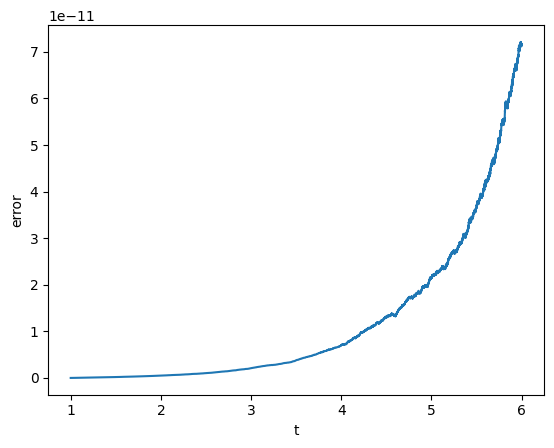

7.213429853436537e-11


In [3]:
#tính sai số
y_exact = [np.exp(t) for t in t_values]
error = np.abs(np.array(y_values) - np.array(y_exact))
#vẽ đồ thị sai số
plt.plot(t_values, error)
plt.xlabel('t')
plt.ylabel('error')
# plt.yscale('log')
plt.show()
print(max(error))

=== Kết quả giải DDE second-class CRK (adaptive, không biết break points) ===
t = 1.000, y = 2.718282
t = 1.005, y = 2.731577
t = 1.011, y = 2.747289
t = 1.017, y = 2.764707
t = 1.024, y = 2.783292
t = 1.031, y = 2.802670
t = 1.038, y = 2.822599
t = 1.045, y = 2.842926
t = 1.052, y = 2.863555
t = 1.059, y = 2.884428
t = 1.067, y = 2.905512
t = 1.074, y = 2.926784
t = 1.081, y = 2.948233
t = 1.089, y = 2.969851
t = 1.096, y = 2.991636
t = 1.103, y = 3.013585
t = 1.110, y = 3.035698
t = 1.118, y = 3.057974
t = 1.125, y = 3.080414
t = 1.132, y = 3.103020
t = 1.140, y = 3.125791
t = 1.147, y = 3.148730
t = 1.154, y = 3.171837
t = 1.162, y = 3.195113
t = 1.169, y = 3.218559
t = 1.176, y = 3.242178
t = 1.184, y = 3.265969
t = 1.191, y = 3.289935
t = 1.198, y = 3.314077
t = 1.205, y = 3.338395
t = 1.213, y = 3.362892
t = 1.220, y = 3.387568
t = 1.227, y = 3.412425
t = 1.235, y = 3.437464
t = 1.242, y = 3.462686
t = 1.249, y = 3.488093
t = 1.257, y = 3.513687
t = 1.264, y = 3.539468
t = 1.271,

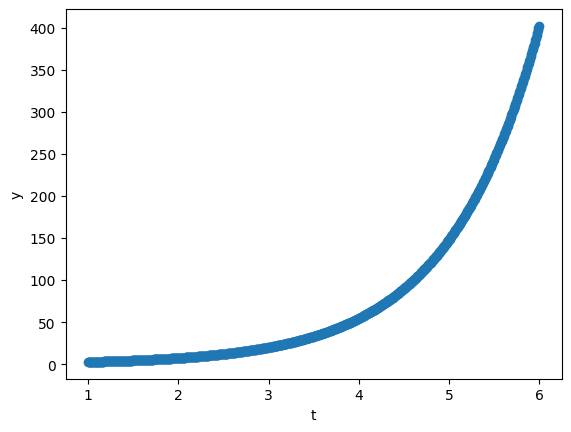

In [6]:
import numpy as np

# ============================================================
# (A) Đa thức b_i(theta) cho nghiệm bậc 4 (second-class)
# ============================================================
def b1_4(theta):
    return (1.0/6.0)*(-3.0*theta**3 + 6.0*theta**2 - 3.0*theta)

def b2_4(theta):
    return (1.0/6.0)*(9.0*theta**3 - 18.0*theta**2 + 9.0*theta)

def b3_4(theta):
    return (1.0/6.0)*(-9.0*theta**3 + 18.0*theta**2 - 9.0*theta)

def b4_4(theta):
    return (1.0/6.0)*(3.0*theta**3)

def b5_4(theta, alpha=1.0):
    # stage phụ, bậc 4, triệt tiêu tại 0 và 1
    return alpha*(theta**2)*((1.0 - theta)**2)

def b_extra_4(theta, alpha=1.0):
    return np.array([b1_4(theta), b2_4(theta), b3_4(theta), b4_4(theta), b5_4(theta, alpha)])


# ============================================================
# (B) Bảng Butcher "RK4 + 1 stage phụ" cho nghiệm bậc 4
#     + một bộ b' nhúng (order 3) để ước lượng sai số
# ============================================================
# 5 stage:
c = np.array([0.0, 0.5, 0.5, 1.0, 2.0/3.0])
A = np.zeros((5,5))
A[1,0] = 0.5
A[2,1] = 0.5
A[3,2] = 1.0
A[4,0] = 2.0/3.0  # stage phụ k5

# "b_main" bậc 4 (giống RK4):
b_main_4 = np.array([1.0/6.0, 1.0/3.0, 1.0/3.0, 1.0/6.0, 0.0])

# "b_embed_3" bậc 3 (chẳng hạn):
# ta chọn tạm: (2/9, 1/3, 4/9, 0, 0) => bậc 3, 
# hoặc một bộ embed quen thuộc. 
# Đây chỉ là ví dụ minh họa.
b_embed_3 = np.array([2.0/9.0, 1.0/3.0, 4.0/9.0, 0.0, 0.0])


# ============================================================
# (C) Tính 1 bước "second-class" + sai số nhúng
# ============================================================
def second_class_rk_step(
    t_n, y_n, h, 
    f_dde, tau_dde, get_y_history,
    alpha_b5=1.0
):
    """
    Tính 1 bước RK4 + 1 stage phụ (second-class),
    kèm ước lượng sai số bậc 3 (embedded).
    
    Trả về:
      y_np1_4:  xấp xỉ bậc 4 (chính)
      y_np1_3:  xấp xỉ bậc 3 (để ước lượng sai số)
      k[]:      mảng 5 stage
    """
    k = [None]*5
    for i in range(5):
        t_i = t_n + c[i]*h
        
        # y_i = y_n + h * sum_{j=0..i-1} A[i,j]*k[j]
        sum_stages = 0.0
        for j in range(i):
            sum_stages += A[i,j]*k[j]
        y_i = y_n + h*sum_stages
        
        # Tính y_delay
        delay_val = tau_dde(t_i, y_i)
        t_delay = t_i - delay_val
        y_delay = get_y_history(t_delay)
        
        # k_i = f_dde(t_i, y_i, y_delay)
        k[i] = f_dde(t_i, y_i, y_delay)
    
    # Nghiệm bậc 4
    incr_4 = 0.0
    for i in range(5):
        incr_4 += b_main_4[i]*k[i]
    y_np1_4 = y_n + h*incr_4
    
    # Nghiệm bậc 3 (embedded)
    incr_3 = 0.0
    for i in range(5):
        incr_3 += b_embed_3[i]*k[i]
    y_np1_3 = y_n + h*incr_3
    
    return y_np1_4, y_np1_3, k

def build_poly_data(t_n, y_n, h, k, alpha_b5):
    """
    Lưu thông tin để nội suy bậc 4 second-class:
    y_n(\theta) = y_n + h * sum_i [b_i^4(\theta)*k_i].
    """
    return {
        't_start': t_n,
        'y_start': y_n,
        'h': h,
        'k': k[:],
        'alpha': alpha_b5
    }

def crk_interpolate(t_query, poly_data):
    """
    Nội suy bậc 4 second-class trên đoạn [t_n, t_n + h].
    """
    t_n = poly_data['t_start']
    y_n = poly_data['y_start']
    h   = poly_data['h']
    k   = poly_data['k']
    alpha = poly_data['alpha']
    
    theta = (t_query - t_n)/h
    if theta <= 0:
        return y_n
    if theta >= 1:
        # trả về giá trị cuối
        return y_n + h*sum(b_main_4[i]*k[i] for i in range(5))
    
    b_vec = b_extra_4(theta, alpha)
    val = y_n
    for i in range(5):
        val += h*b_vec[i]*k[i]
    return val

# ============================================================
# (D) Solver DDE với kiểm soát sai số & phát hiện "gián đoạn ẩn"
# ============================================================
class SecondClassCRK_Adaptive_DDE:
    def __init__(self, f, tau, phi, t0, t_end, 
                 h_init=0.1, 
                 rtol=1e-5, atol=1e-7, 
                 alpha_b5=1.0, 
                 h_max=np.inf, 
                 max_steps=100000):
        """
        f, tau:  hàm f_dde(t,y,y_delay), tau_dde(t,y)
        phi:     hàm lịch sử cho t < t0
        t0, t_end: miền tính
        h_init:  bước ban đầu
        rtol, atol: ngưỡng sai số tương đối & tuyệt đối
        alpha_b5:  hệ số alpha trong b5
        h_max:   bước tối đa
        max_steps: giới hạn số bước
        """
        self.f = f
        self.tau = tau
        self.phi = phi
        self.t0 = t0
        self.t_end = t_end
        self.h_init = h_init
        self.rtol = rtol
        self.atol = atol
        self.alpha_b5 = alpha_b5
        self.h_max = h_max
        self.max_steps = max_steps
        
        # Kết quả
        self.times = []
        self.values = []
        self.segments = []
    
    def solve(self):
        # Hàm lấy y(t_query) từ lịch sử + nội suy
        def get_y_history(t_query):
            if t_query <= self.t0:
                return self.phi(t_query)
            # Tìm segment chứa t_query
            for seg in reversed(self.segments):
                t_start = seg['t_start']
                h_seg = seg['h']
                if t_query >= t_start and t_query <= t_start + h_seg:
                    return crk_interpolate(t_query, seg)
            # Nếu vượt ngoài, trả về giá trị cuối
            return self.values[-1]
        
        t_n = self.t0
        y_n = self.phi(t_n)
        h = self.h_init
        
        self.times = [t_n]
        self.values = [y_n]
        self.segments = []
        
        step_count = 0
        
        while t_n < self.t_end and step_count < self.max_steps:
            if t_n + h > self.t_end:
                h = self.t_end - t_n
            
            # 1) Tính thử 1 bước
            y_try_4, y_try_3, k_stages = second_class_rk_step(
                t_n, y_n, h,
                self.f, self.tau,
                get_y_history,
                alpha_b5=self.alpha_b5
            )
            
            # 2) Ước lượng sai số
            #    e = |y4 - y3|, 
            #    xem nó so với tol = atol + rtol*max(|y4|, |y3|)
            scale = self.atol + self.rtol * max(abs(y_try_4), abs(y_try_3), abs(y_n))
            err_est = abs(y_try_4 - y_try_3)
            if err_est < 1e-30:
                err_est = 1e-30  # tránh chia 0
            
            ratio = err_est / scale
            
            # 3) Kiểm tra "nhảy" k_i (phát hiện gián đoạn tiềm ẩn)
            jump_suspect = False
            for i in range(1,5):
                if k_stages[i] is not None and k_stages[i-1] is not None:
                    if abs(k_stages[i] - k_stages[i-1]) > 100.0 * max(1e-14, abs(k_stages[i-1])):
                        # ví dụ: nếu k_i gấp 100 lần k_{i-1} => nghi ngờ
                        jump_suspect = True
                        break
            
            # 4) Nếu sai số > 1 => thất bại => giảm h
            #    Hoặc nếu jump_suspect => giảm h
            if ratio > 1.0 or jump_suspect:
                h_new = 0.5 * h * (1.0 / ratio)**0.25  if ratio>1 else 0.5*h
                # Giới hạn h_new
                h = max(h_new, 1e-12)
                continue  # thử lại bước này
            else:
                # 5) Chấp nhận bước
                t_n += h
                y_n = y_try_4
                step_count += 1
                
                self.times.append(t_n)
                self.values.append(y_n)
                
                # Lưu poly_data
                poly_data = build_poly_data(t_n - h, self.values[-2], h, k_stages, self.alpha_b5)
                self.segments.append(poly_data)
                
                # 6) Điều chỉnh h cho bước sau (nếu sai số rất nhỏ => tăng)
                safety = 0.9
                factor = (1.0/ratio)**0.2
                h_new = h * min(5.0, max(0.2, safety*factor))
                h_new = min(h_new, self.h_max)
                h = h_new
        
        return np.array(self.times), np.array(self.values)

# ============================================================
# (E) Ví dụ chạy thử
# ============================================================
if __name__ == "__main__":
    def f_example(t, y, y_delay):
        return np.e**2*y_delay

    def tau_example(t, y):
        # Delay hằng số
        return 2.0

    def phi_example(t):
        # Hàm lịch sử, giả sử là hàm mũ trên t<=t0
        return np.e**t
    
    solver = SecondClassCRK_Adaptive_DDE(
        f_example, tau_example, phi_example,
        t0=1.0, t_end=6,
        h_init=0.01, h_max=0.5,
        rtol=1e-5, atol=1e-7,
        alpha_b5=1.0
    )
    
    T, Y = solver.solve()
    
    print("=== Kết quả giải DDE second-class CRK (adaptive, không biết break points) ===")
    for tt, yy in zip(T, Y):
        print(f"t = {tt:.3f}, y = {yy:.6f}")
#vẽ đồ thị
import matplotlib.pyplot as plt
plt.plot(T, Y, 'o-')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

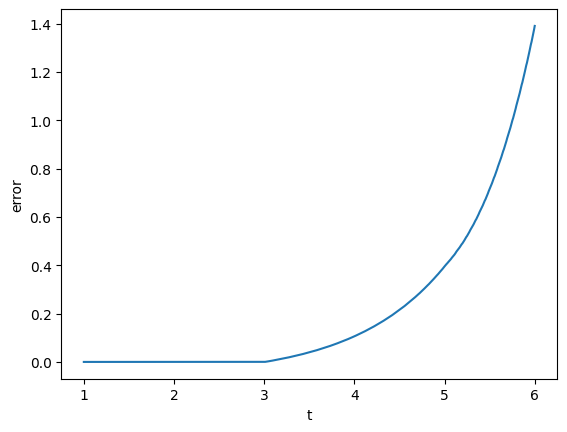

In [7]:
#tính sai số
y_exact = [np.exp(t) for t in T]
error = np.abs(np.array(Y) - np.array(y_exact))
#vẽ đồ thị sai số
plt.plot(T, error)
plt.xlabel('t')
plt.ylabel('error')
plt.show()

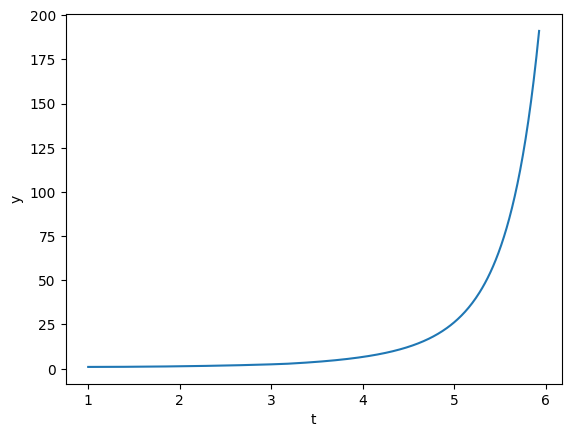

26.340608506070307


In [34]:
from scipy.integrate import quad
XI1 = 3.1461932206205825852
XI2 = 5.9254498245082464926

def integrand(s, lambda_val=1):
    """Hàm tích phân cho đoạn [XI1, XI2]."""
    term_inside_log = s * (s - np.log(s) - 1)
    exponent_part = lambda_val * (s - np.log(term_inside_log) - 2 * lambda_val)
    base_part = lambda_val ** ((s - 1) / s)
    return base_part * np.exp(exponent_part)
def y_exact(t, lambda_val):
    """Tính giá trị của hàm y(t) tại điểm t với tham số lambda."""
    if t < 1 or t > XI2:
        raise ValueError(f"t phải thuộc đoạn [1, {XI2}]")
    
    if t <= XI1:
        return np.exp(lambda_val * (t - np.log(t) - 1))
    else:
        # Tính tích phân từ XI1 đến t
        integral, _ = quad(integrand, XI1, t, args=(lambda_val,), epsabs=1e-12, epsrel=1e-12)
        return np.exp(lambda_val + integral)
#vẽ đồ thị nghiệm chính xác trên [1, XI2]
t_values = np.linspace(1, XI2, num=500)
y_values = [y_exact(t, lambda_val=1) for t in t_values]
plt.plot(t_values, y_values)
plt.xlabel('t')
plt.ylabel('y')
plt.show()
print(y_exact(5, 1))

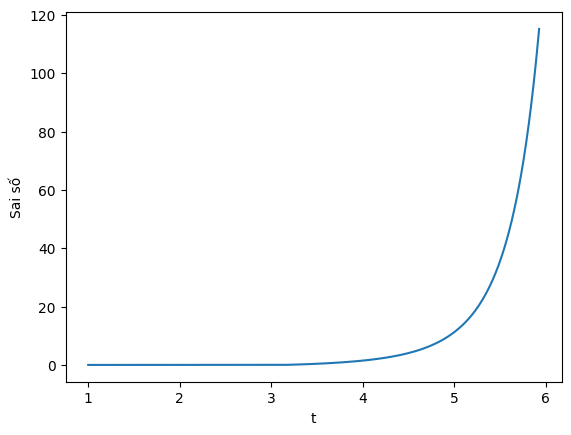

In [12]:
#tính sai số trên đoạn [1, XI2] với lambda=1
y_exact_values = [y_exact(t, 1) for t in T]
errors = np.abs(Y - y_exact_values)
#vẽ đồ thị sai số
plt.plot(T, errors)
plt.xlabel('t')
plt.ylabel('Sai số')
plt.show()

In [13]:
print("Sai số tối đa:", np.max(errors))

Sai số tối đa: 115.21306995406694


ba châm hơn :))))))))))

t = 1.000, y = 2.71828
t = 1.001, y = 2.72100
t = 1.002, y = 2.72372
t = 1.003, y = 2.72645
t = 1.004, y = 2.72918
t = 1.005, y = 2.73191
t = 1.006, y = 2.73464
t = 1.007, y = 2.73738
t = 1.008, y = 2.74012
t = 1.009, y = 2.74286
t = 1.010, y = 2.74560
t = 1.011, y = 2.74835
t = 1.012, y = 2.75110
t = 1.013, y = 2.75385
t = 1.014, y = 2.75661
t = 1.015, y = 2.75936
t = 1.016, y = 2.76212
t = 1.017, y = 2.76489
t = 1.018, y = 2.76765
t = 1.019, y = 2.77042
t = 1.020, y = 2.77319
t = 1.021, y = 2.77597
t = 1.022, y = 2.77875
t = 1.023, y = 2.78153
t = 1.024, y = 2.78431
t = 1.025, y = 2.78710
t = 1.026, y = 2.78988
t = 1.027, y = 2.79268
t = 1.028, y = 2.79547
t = 1.029, y = 2.79827
t = 1.030, y = 2.80107
t = 1.031, y = 2.80387
t = 1.032, y = 2.80667
t = 1.033, y = 2.80948
t = 1.034, y = 2.81229
t = 1.035, y = 2.81511
t = 1.036, y = 2.81792
t = 1.037, y = 2.82074
t = 1.038, y = 2.82356
t = 1.039, y = 2.82639
t = 1.040, y = 2.82922
t = 1.041, y = 2.83205
t = 1.042, y = 2.83488
t = 1.043, 

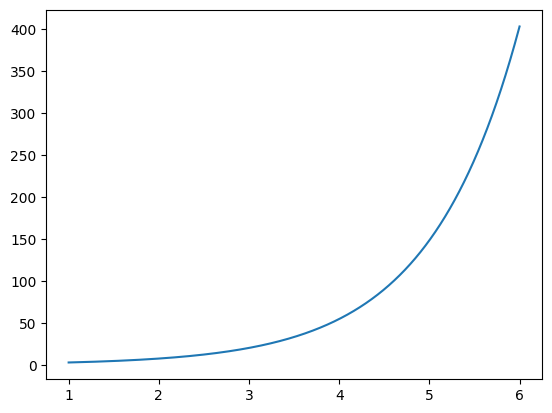

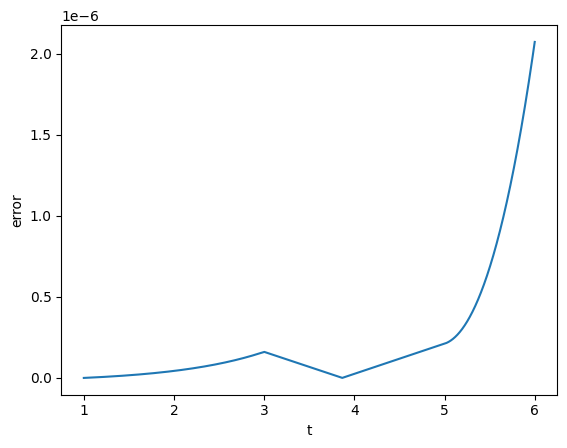

In [19]:
import numpy as np

class DDE_CRK_SecondClass:
    """
    Giải DDE với phương pháp Continuous Runge-Kutta có second class interpolants,
    sử dụng scheme cấp 4 với 4 stage chính và 1 stage phụ (nội suy).
    
    Các nút nội suy:
        c1 = 0, c2 = 1/3, c3 = 0.5, c4 = 2/3, c5 = 1.
    """
    def __init__(self, f, tau, phi, t_0, y0, t_final,
                 h_init=0.1, h_min=1e-6, h_max=0.5):
        """
        f      : hàm f(t, u, v) = f(t, y(t), y(t - tau(t, y(t))))
        tau    : hàm trễ tau(t, y)
        phi    : hàm điều kiện đầu, y(t)=phi(t) với t<=t_0
        t_0    : thời điểm bắt đầu
        y0     : y(t_0)
        t_final: thời điểm kết thúc
        h_init, h_min, h_max: bước ban đầu, nhỏ nhất, lớn nhất
        """
        self.f = f
        self.tau = tau
        self.phi = phi
        self.t_0 = t_0
        self.y0 = y0
        self.t_final = t_final
        self.h_init = h_init
        self.h_min = h_min
        self.h_max = h_max

        # Lưu trữ nghiệm
        self.times = [t_0]
        self.sol = [y0]
        self.K_stages_list = []  # lưu các stage K1,...,K5 cho mỗi bước

        # Định nghĩa scheme theo thứ tự tăng dần của nút:
        #  Stage 1: c = 0      (chính, ban đầu)
        #  Stage 2: c = 1/3    (chính)
        #  Stage 3: c = 0.5    (phụ, chỉ dùng nội suy)
        #  Stage 4: c = 2/3    (chính)
        #  Stage 5: c = 1      (chính)
        self.c = np.array([0, 1/3, 0.5, 2/3, 1.0])
        
        # Ma trận A 5x5 (lower-triangular) với các hệ số được chọn như sau:
        self.A = np.zeros((5,5))
        # Stage 1: không cần cập nhật (đã có y_n)
        # Stage 2: y2 = y_n + h*(1/3*K1)
        self.A[1, 0] = 1/3
        # Stage 3 (phụ): y3 = y_n + h*(0.2*K1 + 0.3*K2) sao cho 0.2+0.3=0.5
        self.A[2, 0] = 0.2
        self.A[2, 1] = 0.3
        # Stage 4: y4 = y_n + h*(0*K1 + (2/3)*K2 + 0*K3)
        self.A[3, 1] = 2/3
        # Stage 5: y5 = y_n + h*(0*K1 + 0*K2 + 1.0*K3 + 0*K4)
        self.A[4, 2] = 1.0
        
        # Cập nhật y_{n+1} chỉ sử dụng các stage chính (không dùng stage phụ – ở đây stage 3)
        # Theo công thức tương tự RK4:
        # y_{n+1} = y_n + h*(1/6*K1 + 1/3*K2 + 1/3*K4 + 1/6*K5)
        self.b_main = np.array([1/6, 1/3, 0, 1/3, 1/6])
        
        # Xây dựng các nút nội suy distinct: chính là các giá trị trong self.c (đã sắp xếp)  
        # và sử dụng điểm đầu 0 và điểm cuối 1 (đã có trong self.c).
        self.X_interp = self.c  # [0, 1/3, 0.5, 2/3, 1.0]

    def _lagrange_basis(self, x_nodes, k, theta):
        """Tính Lagrange cơ bản L_k(theta) với x_nodes (đã distinct)."""
        L = 1.0
        xk = x_nodes[k]
        for m, xm in enumerate(x_nodes):
            if m != k:
                L *= (theta - xm) / (xk - xm)
        return L

    def history_solution(self, t_query):
        """
        Trả về nghiệm xấp xỉ y(t_query) dựa vào nội suy trên bước [t_n, t_{n+1}].
        Nếu t_query < t_0 thì trả về phi(t_query).
        Nếu t_query vượt ngoài khoảng đã tính, trả về giá trị cuối.
        """
        if t_query <= self.t_0:
            return self.phi(t_query)
        t_end = self.times[-1]
        if t_query >= t_end:
            return self.sol[-1]
        
        # Tìm đoạn [t_n, t_{n+1}] chứa t_query
        for i in range(len(self.times)-1):
            t_n = self.times[i]
            t_np1 = self.times[i+1]
            if t_n <= t_query <= t_np1:
                h = t_np1 - t_n
                theta = (t_query - t_n) / h

                # Lấy dữ liệu của bước i:
                y_n = self.sol[i]
                K_stages = self.K_stages_list[i]  # danh sách các K theo thứ tự scheme
                
                # Xây dựng các giá trị nội suy Y_vals ứng với các nút trong X_interp:
                # Y[0] = y_n (nút 0, c=0)
                # Y[1] = y_n + h*(A[1,0]*K1)           (nút 1, c=1/3)
                # Y[2] = y_n + h*(A[2,0]*K1 + A[2,1]*K2) (nút 2, c=0.5)  -> stage phụ
                # Y[3] = y_n + h*(A[3,0]*K1 + A[3,1]*K2 + A[3,2]*K3) (nút 3, c=2/3)
                # Y[4] = y_{n+1}                       (nút 4, c=1)
                Y_vals = [None]*5
                Y_vals[0] = y_n
                for j in range(1, 4):
                    y_stage = np.copy(y_n)
                    for m in range(j):
                        y_stage += h * self.A[j, m] * K_stages[m]
                    Y_vals[j] = y_stage
                # Tính y_{n+1} từ cập nhật chính:
                y_np1 = y_n + h * np.sum([self.b_main[j] * K_stages[j] for j in range(5)], axis=0)
                Y_vals[4] = y_np1
                
                # Nội suy bằng Lagrange trên các nút distinct X_interp:
                val = np.zeros_like(y_n, dtype=float)
                for k in range(5):
                    Lk = self._lagrange_basis(self.X_interp, k, theta)
                    val += Lk * Y_vals[k]
                return val
        return None

    def _compute_stages(self, t_n, y_n, h):
        """
        Tính các stage theo scheme đã định nghĩa (theo thứ tự của self.c).
        Trả về danh sách [K1, K2, K3, K4, K5] (trong đó K3 là stage phụ).
        """
        K = []
        for j in range(5):
            t_stage = t_n + self.c[j] * h
            y_stage = np.copy(y_n)
            for m in range(j):
                y_stage += h * self.A[j, m] * K[m]
            delay = self.tau(t_stage, y_stage)
            t_delay = t_stage - delay
            y_delay = self.history_solution(t_delay)
            K_j = self.f(t_stage, y_stage, y_delay)
            K.append(K_j)
        return K

    def step(self, t_n, y_n, h):
        """
        Thực hiện 1 bước từ (t_n, y_n) đến (t_n+h, y_{n+1}).
        """
        K_stages = self._compute_stages(t_n, y_n, h)
        y_np1 = np.copy(y_n) + h * np.sum([self.b_main[j] * K_stages[j] for j in range(5)], axis=0)
        return (t_n + h, y_np1, K_stages)

    def solve(self):
        """
        Giải từ t_0 đến t_final với bước tích phân (không adaptive).
        """
        t_n = self.t_0
        y_n = self.y0
        h = self.h_init
        while t_n < self.t_final - 1e-15:
            if t_n + h > self.t_final:
                h = self.t_final - t_n
            t_np1, y_np1, K_stages = self.step(t_n, y_n, h)
            self.times.append(t_np1)
            self.sol.append(y_np1)
            self.K_stages_list.append(K_stages)
            t_n = t_np1
            y_n = y_np1
            if h < self.h_max:
                h = min(2 * h, self.h_max)
        return np.array(self.times), np.array(self.sol)


# ===============================
# Ví dụ sử dụng
# ===============================
def demo_second_class():
    import numpy as np
    # Định nghĩa hàm f, tau, phi
    def f(t, y, y_delay):
        return np.e**2*y_delay

    def tau(t, y):
        # Delay hằng số
        return 2.0

    def phi(t):
        # Hàm lịch sử, giả sử là hàm mũ trên t<=t0
        return np.e**t

    # Lưu ý: chọn t_0=1 (vì tau và f có mũi tên t>0) và y0 = phi(1)
    solver = DDE_CRK_SecondClass(
        f=f, tau=tau, phi=phi,
        t_0=1, y0=phi(1), t_final=6,
        h_init=1e-3, h_min=1e-8, h_max=1e-4
    )
    
    t_vals, y_vals = solver.solve()
    for (tt, yy) in zip(t_vals[::1], y_vals[::1]):
        print(f"t = {tt:.3f}, y = {yy:.5f}")
    return t_vals, y_vals
if __name__ == "__main__":
    sol = demo_second_class()
    #Vẽ đồ thị nghiệm số
    print(len(sol[0]))
    import matplotlib.pyplot as plt

    plt.plot(sol[0], sol[1])
    plt.show()
    #tính sai số
    y_exact = [np.exp(t) for t in sol[0]]
    error = np.abs(np.array(sol[1]) - np.array(y_exact))
    #vẽ đồ thị sai số
    plt.plot(sol[0], error)
    plt.xlabel('t')
    plt.ylabel('error')
    plt.show()


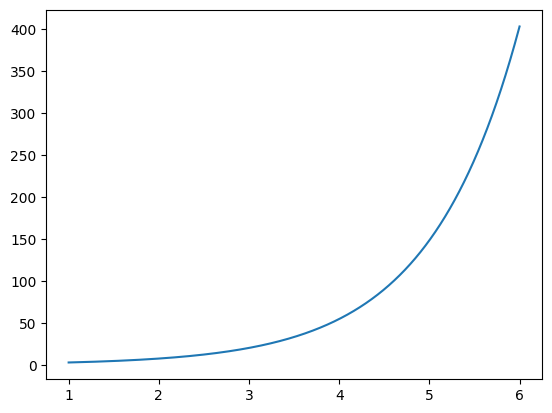

In [20]:
import numpy as np
from typing import Callable, List, Tuple

def solve_dde_crk4(
    f: Callable[[float, float, float], float],
    tau: Callable[[float, float], float],
    phi: Callable[[float], float],
    t0: float,
    T: float,
    y0: float = None,
    h: float = 0.1,
) -> Tuple[np.ndarray, np.ndarray, List[Callable[[float], float]]]:
    """
    Giải DDE: y'(t) = f(t, y(t), y(t - tau(t,y(t)))) bằng RK4 + nội suy liên tục (first class).
    
    Tham số:
    --------
    f   : hàm f(t, u, v)
    tau : hàm tau(t, u) trả về độ trễ
    phi : hàm phi(t) - điều kiện ban đầu cho t <= t0
    t0  : thời điểm bắt đầu
    T   : thời điểm kết thúc
    y0  : giá trị y(t0), nếu None sẽ dùng phi(t0)
    h   : bước thời gian (cố định trong ví dụ)
    
    Trả về:
    --------
    times       : mảng thời gian [t0, t1, ..., tN]
    solutions   : mảng nghiệm xấp xỉ [Y0, Y1, ..., YN]
    polynomials : danh sách các đa thức nội suy P_n cho mỗi đoạn [t_n, t_{n+1}]
                  polynomials[n](t) sẽ xấp xỉ y(t) trong đoạn đó.
    """
    
    if y0 is None:
        y0 = phi(t0)
    
    # Lưu các nút thời gian
    times = [t0]
    # Lưu nghiệm xấp xỉ tại các nút
    solutions = [y0]
    # Lưu các đa thức nội suy (mỗi đoạn là một hàm Python)
    polynomials = []
    
    # Đặt t hiện tại
    t_current = t0
    Y_current = y0
    
    # Hàm phụ để nội suy Lagrange bậc 3 (hoặc 4) cho 4 điểm:
    # (0, P(0)), (c2, P(c2)), (c3, P(c3)), (1, P(1)).
    # Ở đây c2=1/2, c3=1/2, c4=1 cho RK4 cổ điển.
    def lagrange_interpolator(x_vals, y_vals):
        """
        Trả về hàm p(x) nội suy Lagrange đi qua các điểm (x_vals[i], y_vals[i]).
        """
        def p(x):
            s = 0.0
            for i in range(len(x_vals)):
                # Tính đa thức cơ sở L_i(x)
                L_i = 1.0
                for j in range(len(x_vals)):
                    if j != i:
                        L_i *= (x - x_vals[j]) / (x_vals[i] - x_vals[j])
                s += y_vals[i] * L_i
            return s
        return p
    
    # Vòng lặp tiến hành cho tới khi t_current >= T
    while t_current < T - 1e-15:  # trừ nhỏ để tránh sai sót số
        # Điều chỉnh bước h nếu vượt quá T
        if t_current + h > T:
            h = T - t_current
        
        # Các hằng số của RK4 cổ điển
        a21 = a32 = a43 = 0.5
        c2 = c3 = 0.5
        c4 = 1.0
        b1 = b4 = 1.0/6.0
        b2 = b3 = 1.0/3.0
        
        # Tính k1
        t_n = t_current
        y_n = Y_current
        delay_n = t_n - tau(t_n, y_n)
        # Lấy y trễ
        if delay_n < t0:
            y_delay_n = phi(delay_n)
        else:
            # Tìm đoạn polynomials[m] chứa delay_n
            # (ở ví dụ đơn giản này, ta duyệt ngược)
            y_delay_n = None
            for idx in reversed(range(len(polynomials))):
                t_start = times[idx]
                t_end   = times[idx+1]
                if (delay_n >= t_start) and (delay_n <= t_end):
                    y_delay_n = polynomials[idx](delay_n)
                    break
            if y_delay_n is None:
                # Nếu vẫn không thấy, thì lấy phi (trường hợp hiếm khi t0>delay_n)
                y_delay_n = phi(delay_n)
        
        k1 = f(t_n, y_n, y_delay_n)
        
        # Tính k2
        t_n2 = t_n + c2*h
        y_n2 = y_n + a21*h*k1
        delay_n2 = t_n2 - tau(t_n2, y_n2)
        # Tìm y_delay_n2
        if delay_n2 < t0:
            y_delay_n2 = phi(delay_n2)
        else:
            y_delay_n2 = None
            for idx in reversed(range(len(polynomials))):
                t_start = times[idx]
                t_end   = times[idx+1]
                if (delay_n2 >= t_start) and (delay_n2 <= t_end):
                    y_delay_n2 = polynomials[idx](delay_n2)
                    break
            if y_delay_n2 is None:
                y_delay_n2 = phi(delay_n2)
        
        k2 = f(t_n2, y_n2, y_delay_n2)
        
        # Tính k3
        t_n3 = t_n + c3*h
        y_n3 = y_n + a32*h*k2
        delay_n3 = t_n3 - tau(t_n3, y_n3)
        if delay_n3 < t0:
            y_delay_n3 = phi(delay_n3)
        else:
            y_delay_n3 = None
            for idx in reversed(range(len(polynomials))):
                t_start = times[idx]
                t_end   = times[idx+1]
                if (delay_n3 >= t_start) and (delay_n3 <= t_end):
                    y_delay_n3 = polynomials[idx](delay_n3)
                    break
            if y_delay_n3 is None:
                y_delay_n3 = phi(delay_n3)
        
        k3 = f(t_n3, y_n3, y_delay_n3)
        
        # Tính k4
        t_n4 = t_n + c4*h
        y_n4 = y_n + a43*h*k3
        delay_n4 = t_n4 - tau(t_n4, y_n4)
        if delay_n4 < t0:
            y_delay_n4 = phi(delay_n4)
        else:
            y_delay_n4 = None
            for idx in reversed(range(len(polynomials))):
                t_start = times[idx]
                t_end   = times[idx+1]
                if (delay_n4 >= t_start) and (delay_n4 <= t_end):
                    y_delay_n4 = polynomials[idx](delay_n4)
                    break
            if y_delay_n4 is None:
                y_delay_n4 = phi(delay_n4)
        
        k4 = f(t_n4, y_n4, y_delay_n4)
        
        # Cập nhật Y_{n+1}
        Y_next = y_n + h*(b1*k1 + b2*k2 + b3*k3 + b4*k4)
        
        # Tạo đa thức nội suy P_n(θ) trên [0,1]
        # Ta có 4 điểm: θ=0, θ=c2=0.5, θ=c3=0.5, θ=1
        # Ở mỗi điểm, ta biết giá trị:
        # P_n(0) = y_n
        # P_n(c2=0.5) = y_n + a21*h*k1 = y_n2
        # P_n(c3=0.5) = y_n + a32*h*k2 = y_n3  (trùng c2=0.5, thực ra RK4 c2=c3=0.5,
        #                                      nên hai giá trị trung gian có thể dùng 1 đa thức bậc 3 "fit" 3 hoặc 4 điểm.)
        # P_n(1) = Y_next
        # Để đơn giản, ta lấy 3 điểm: 0, 0.5, 1 (bỏ qua trung gian lặp c3=0.5).
        
        x_vals = [0.0, 0.5, 1.0]
        y_vals = [y_n, y_n2, Y_next]  # y_n3 cũng = y_n2 trong RK4 c2=c3=0.5, 
                                      # nhưng nếu muốn chính xác hơn, ta có thể làm nội suy bậc 3 hoặc 4 với 4 điểm
        # Ở đây làm đơn giản bậc 2
        poly_local = lagrange_interpolator(x_vals, y_vals)
        
        # Định nghĩa hàm p_n(t) trên đoạn [t_n, t_{n+1}]
        def p_n_factory(tn, h_local, poly):
            def p_n(t_query):
                # quy đổi về theta
                theta = (t_query - tn)/h_local
                return poly(theta)
            return p_n
        
        p_n = p_n_factory(t_n, h, poly_local)
        
        # Lưu kết quả
        t_current += h
        Y_current = Y_next
        
        times.append(t_current)
        solutions.append(Y_current)
        polynomials.append(p_n)
    
    return np.array(times), np.array(solutions), polynomials


# =========================
# Ví dụ sử dụng đơn giản
if __name__ == "__main__":

    def f(t, y, y_delay):
        return np.e**2*y_delay

    def tau(t, y):
        # Delay hằng số
        return 2.0

    def phi(t):
        # Hàm lịch sử, giả sử là hàm mũ trên t<=t0
        return np.e**t
    
    t0 = 1.0
    T  = 6.0
    h  = 1e-3
    
    times, sols, polys = solve_dde_crk4(f, tau, phi, t0, T, y0=None, h=h)
    
    # In ra một vài kết quả
    # for i in range(len(times)):
    #     print(f"t = {times[i]:.2f}, y ~ {sols[i]:.6f}")
    
    # # Thử lấy giá trị ở giữa đoạn [t_n, t_{n+1}] qua nội suy
    # # (chẳng hạn times[1] - times[0] = h)
    # # p_0(t0 + 0.5*h) ~ y(t0 + 0.5*h)
    # if len(polys) > 0:
    #     mid_point = times[0] + 0.5*h
    #     val_mid   = polys[0](mid_point)
    #     print(f"Nội suy tại t = {mid_point:.2f} cho bước đầu: y ~ {val_mid:.6f}")
    #vẽ đồ thị
    import matplotlib.pyplot as plt

    plt.plot(times, sols)
    plt.show()


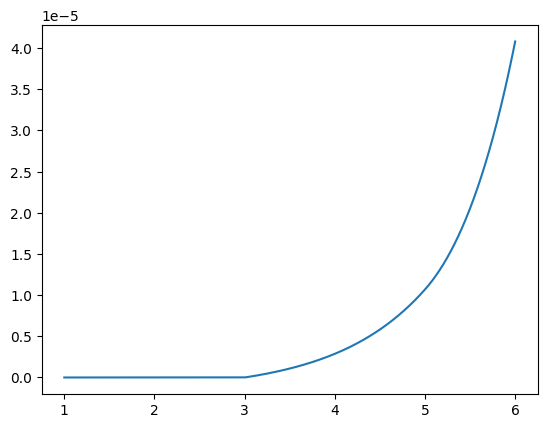

In [21]:
#Tính sai số
errors = np.abs(sols - np.array([np.exp(t) for t in times]))
plt.plot(times, errors)
plt.show()